# Continuous Time Markov Chains

## Overview

To be added.  Focus is on time-homogeneous chains.  Finite state space.


We will use the following imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


## Poisson Processes

We will use a well-known relationship between exponential and Poisson
random variables.

In what follows, $Y \sim E(\lambda)$ means that $Y$ is exponential with rate $\lambda$,
so 

$$
    \mathbb P\{Y > y\} = e^{-\lambda y}
    \quad \text{  for all } 
    y \geq 0.
$$

Let $\lambda > 0$ be given and let $\{W_i\}$ be an IID sequence drawn from $E(\lambda)$.

In our context, the sequence $\{W_i\}$ is sometimes called
the **wait times**.

Let

$$
    J_n := W_1 + \cdots W_n 
    \quad \text{with} \quad
    J_0 = 0
$$

For example, if $W_i$ is the amount of time that customer $i$ waits in a
queue, then $J_n$ is the time that the $n$-th customer is served.

Let

$$
    N(t) := \max\{n \geq 0 \,|\, J_n \leq t\}
$$

In this context, $N(t)$ is the number of customers served by time $t$.

As a function of $t$, the process $N(t)$ is called a **counting process**.

It is in fact an example of a continuous time Markov chain, although we put
that aside for now.

In [4]:
# Add simulation that shows a path of N(t), along with the values of J_n

Below we use the following well known result:

**Proposition**  For each $t > 0$, the random variable $N(t)$ has the Poisson
distribution with parameter $t \lambda$, so that

$$ 
    \mathbb P\{N(t) =k\} 
    = \frac{(t \lambda)^k e^{-t \lambda}}{k!}
    \qquad (k = 0, 1, \ldots)
$$

An exercise at the end asks you to test this (informally) via simulation.

[Add exercise]


## Markov Dynamics

Let's start by thinking about how to represent continuous time Markov chains
and how to visualize them.


### Informal Definition

Let $S = \{x_1, \ldots, x_n\}$, where each $x_i$ is a real number.

Informally, a continuous time $S$-valued Markov chain $\{X_t\}$ is an $S$-valued stochastic process indexed by $t \in \mathbb R_+$ that has the Markov property.

Having the Markov property means that $\{X_t\}_{t < r}$ and $\{X_t\}_{t \geq r}$ are independent given $X_r$.

Because the state space is discrete, all movements between states takes the
form of jumps.

We use $J_0, J_1, J_2, \ldots$ to record the jump times, with $J_0 := 0$.

The process is constant between jumps, so that

$$
    X_t = X_{J_k} \text{ for } J_k \leq t < J_{k+1}.
$$

Here's a visualization with $S = \{1, 2, 3\}$.

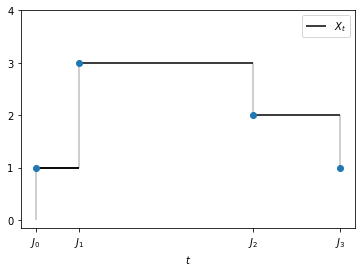

In [5]:
XJs = 1, 3, 2, 1
Js = 0, 0.3, 1.5, 2.1
n = len(Js)

fig, ax = plt.subplots()

ax.plot(Js, XJs, 'o')
ax.hlines(XJs, Js[:-1], Js[1:], label='$X_t$')
ax.vlines(Js, (0, XJs[0], XJs[1], XJs[2]), XJs, alpha=0.25)

ax.set(xticks=Js,
       xticklabels=[f'$J_{k}$' for k in range(n)],
       yticks=(0, 1, 2, 3, 4),
       xlabel='$t$')

ax.legend()
plt.show()


### An Alternative Representation

There is another way to represent the process $\{X_t\}$ that is convenient for
computation.

Let $\{Y_k\}$ with $k=0, 1, \ldots$ record the sequence of distinct values
for the chain.

(That is, $Y_k = X_{J_k}$ for $k=0, 1, \ldots$)

Then 

$$
    X_t = Y_{N(t)}
    \quad \text{where} \quad
    N(t) := \sum_{k \geq 1} \mathbb 1\{J_k \leq t\}
$$ (xfromy)

In particular, we can reconstruct $\{X_t\}$ from the **jump chain sequence** $(J_k, Y_k)$ via {eq}(xfromy).

We can also plot it easily using Matplotlib.

Here's a simulation that illustrates with 

* steps between jumps drawn from an exponential distribution and
* the sequence $\{Y_k\}$ drawn from a discrete time Markov chain.

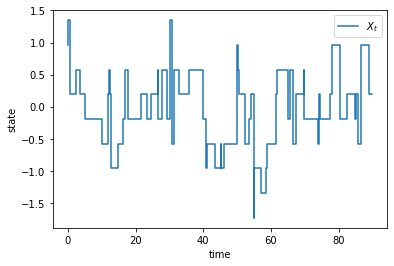

In [99]:
n = 100

# Generate J sequence randomly using exponential step sizes
J = np.zeros(n)
T = np.random.exponential(size=n-1)
J[1:] = np.cumsum(T)

# Generate Y sequence from discrete approximation of an AR(1)
mc = qe.tauchen(0.5, 0.5, n=10)  
Y = mc.simulate(n)

fig, ax = plt.subplots()
ax.step(J, Y, label="$X_t$")

ax.set(xlabel="time", ylabel="state")
ax.legend()
plt.show()


Below we will find out that this particular simulation is very representative.

It's a remarkable fact that *every* continuous time Markov chain on $S$ can be
constructed as follows:

1. Set $J_0 = 0$ and then $J_{k+1} = J_k + \tau_{k+1}$ where each $\tau_i$ is an independent exponential draw.
1. Draw $\{Y_k \}$ from a discrete time Markov chain on $S$.
1. Take $(J_k, Y_k)$ as the jump chain sequence and build $X_t$ as above.

Below, we call this the **jump chain construction**.


### A Simple Example


Let $X_t$ be the inventory of a firm at time $t$,
taking values in the integers $0, 1, \ldots, b$.

If $X_t > 0$, then a customer arrives and purchases one unit after $W$
units of time, where $W \sim E(\lambda)$.

If $X_t = 0$, then no customers arrive and the firm places an order for $b$ units.

The order arrives after $U$ units of time, where $U \sim E(\kappa)$.

Let's simulate this process, starting at $X_0 = 0$.

We will use the idea of a jump chain again, where 

* $\{Y_k\}$ gives the values of the discrete time chain on the jumps
* $\{J_k\}$ gives date of the jumps
* $\{X_t\}$ is defined from these objects via {eq}`xfromy`.

For this particular case, $\{Y_k\}$ updates deterministically, since the only
randomness is the exponential wait times.

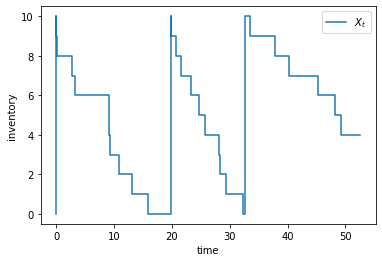

In [45]:
λ, κ = 0.5, 1.0
b = 10
K = 30
J = np.zeros(K)
Y = np.zeros(K)
k = 0

for k in range(K-1):
    if Y[k] == 0:
        τ = np.random.exponential(scale=1/κ)
        Y[k+1] = b
    else:
        τ = np.random.exponential(scale=1/λ)
        Y[k+1] = Y[k] - 1
    J[k+1] = J[k] + τ


fig, ax = plt.subplots()
ax.step(J, Y, label="$X_t$")

ax.set(xlabel="time", ylabel="inventory")

ax.legend()
plt.show()

##  Distribution Dynamics

We continue to study a continuous time Markov chain on discrete state space $S
= \{x_1, \ldots, x_n\}$.

We will start off with a line of argument that seems orthogonal to all of the
discussion above.

Then we will make the connections.

Below,

* $\mathbb 1$ is an $n \times 1$ column vector of ones and
* $D(S)$ is the set of all distributions (pmfs) on $S$.


### Review of the Discrete Time Case

Previously we studied discrete time Markov chains.

We learned that the distribution $\psi_t$ of $X_t$ updates according to 

$$
    \psi_{t+1} = \psi_t P, 
    \qquad \psi_0 \text{ a given element of } D(S),
$$

where 

* $P$ is a Markov matrix (nonnegative and unit row sums) and
* distributions are understood as $1 \times n$ row vectors.

In summary, 

1. distributions update according to a linear difference equation and
2. that difference equation has the property that trajectories remain in $D(S)$.

The second point holds because $P$ is a Markov matrix if and only if $\psi \mapsto \psi P$ send $D(S)$ into itself. (Check it!)

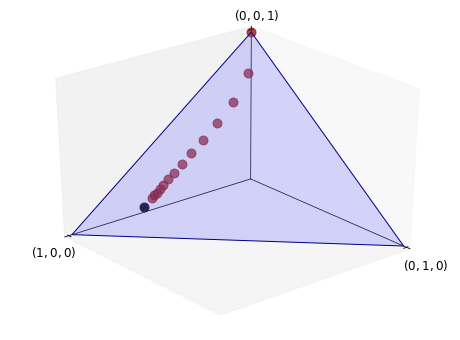

In [46]:
def unit_simplex(angle):
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    vtx = [[0, 0, 1],
           [0, 1, 0], 
           [1, 0, 0]]
    
    tri = Poly3DCollection([vtx], color='darkblue', alpha=0.3)
    tri.set_facecolor([0.5, 0.5, 1])
    ax.add_collection3d(tri)

    ax.set(xlim=(0, 1), ylim=(0, 1), zlim=(0, 1), 
           xticks=(1,), yticks=(1,), zticks=(1,))

    ax.set_xticklabels(['$(1, 0, 0)$'], fontsize=12)
    ax.set_yticklabels(['$(0, 1, 0)$'], fontsize=12)
    ax.set_zticklabels(['$(0, 0, 1)$'], fontsize=12)

    ax.xaxis.majorTicks[0].set_pad(15)
    ax.yaxis.majorTicks[0].set_pad(15)
    ax.zaxis.majorTicks[0].set_pad(35)

    ax.view_init(30, angle)

    # Move axis to origin
    ax.xaxis._axinfo['juggled'] = (0, 0, 0)
    ax.yaxis._axinfo['juggled'] = (1, 1, 1)
    ax.zaxis._axinfo['juggled'] = (2, 2, 0)
    
    ax.grid(False)
    
    return ax


def convergence_plot(ψ, n=14, angle=50):

    ax = unit_simplex(angle)

    # Convergence plot
    P = ((0.9, 0.1, 0.0),
         (0.4, 0.4, 0.2),
         (0.1, 0.1, 0.8))
    
    P = np.array(P)

    ψ = ψ        # Initial condition

    x_vals, y_vals, z_vals = [], [], []
    for t in range(n):
        x_vals.append(ψ[0])
        y_vals.append(ψ[1])
        z_vals.append(ψ[2])
        ψ = ψ @ P

    ax.scatter(x_vals, y_vals, z_vals, c='darkred', s=80, alpha=0.7, depthshade=False)

    mc = qe.MarkovChain(P)
    ψ_star = mc.stationary_distributions[0]
    ax.scatter(ψ_star[0], ψ_star[1], ψ_star[2], c='k', s=80)

    return ψ

ψ = convergence_plot((0, 0, 1))

plt.show()


### Shifting to Continuous Time

In view of the foregoing, for a continuous time Markov chain, we fully expect
the following:

1. distributions update according to a linear *differential* equation and
2. that differential equation is such that trajectories remain in $D(S)$.

The linear differential equation can be expressed as

$$
    \psi_t' = \psi_t Q, 
    \qquad \psi_0 \text{ a given element of } D(S),
$$ (ode_mc)

where 

* $Q$ is an $n \times n$ matrix with suitable properties, 
* distributions are again understood as row vectors, and
* derivatives are taken element by element, so that

$$
    \psi_t' =
    \begin{pmatrix}
        \frac{d}{dt} \psi_t(1) &
        \cdots &
        \frac{d}{dt} \psi_t(n)
    \end{pmatrix}
$$

In [47]:
# Insert simplex figure with flow here, discuss discretization

In this calculation, we chose $Q$ with some care, so that the flow remains in
$D(S)$.

This raises a key question: what properties do we require on $Q$ such that
$\psi_t$ is always in $D(S)$?

We seek necessary and sufficient conditions, so we can determine
exactly the set of continuous time Markov models on our state space.

We will answer this question in stages.

#### Solving the ODE 

A good way first step is to note that the unique
solution to the initial value problem {eq}`ode_mc` is given by 

$$
    \psi_t = \psi_0 P_t 
    \quad \text{where } P_t := e^{tQ}
$$ (cmc_sol)

Here, the right hand side is the [matrix exponential](https://en.wikipedia.org/wiki/Matrix_exponential), with definition 

$$
    e^{tQ} = \sum_{k \geq 0} \frac{1}{k!} (tQ)^k
$$

The derivative of this expression with respect to $t$, working element by
element, is

$$
    \frac{d}{d t} P_t =  Q e^{tQ} = e^{tQ} Q 
$$

We can write the first equality as 

$$
    \frac{d}{d t} P_t =  Q P_t 
$$

This is called the **Kolmogorov backward equation**.  The second equality can
be written as 

$$
    \frac{d}{d t} P_t = P_t Q 
$$

and is called the **Kolmogorov forward equation**.

With $\psi_t$ set to $\psi_0 P_t$ and applying the Kolmogorov forward
equation, we obtain

$$
    \frac{d}{d t} \psi_t 
    = \psi_0 \frac{d}{d t} P_t 
    = \psi_0 P_t Q
    = \psi_t Q
$$

This confirms that {eq}`cmc_sol` solves {eq}`ode_mc`.

For a proof that no other solution exists, see [cite Norris].



#### Preserving Distributions

Recall that the linear update rule $\psi \mapsto \psi P$ is invariant on $D(S)$
if and only if $P$ is a Markov matrix.

So now we can rephrase our key question regarding invariance on $D(S)$:

What properties do we need to impose on $Q$ so that $P_t$ is a Markov matrix
for all $t$?

A square matrix $Q$ is called a **transition rate matrix** if $Q$ has zero row
sums and $Q(i, j) \geq 0$ whenever $i \not= j$.

(Some authors call a transition rate matrix a $Q$ matrix.)

Having zero row sums can be expressed as $Q \mathbb 1 = 0$.

As a small exercise, you can check that the following is true

$$
    Q \text{ has zero row sums }
    \iff
    Q^k \mathbb 1 = 0 \text{ for all } k \geq 1
$$ (zrsnec)

**Theorem** If $Q$ is an $n \times n$ matrix and $P_t := e^{tQ}$, then the
following statements are equivalent:

1. $P_t$ is a Markov matrix for all $t$.
1. $Q$ is a transition rate matrix.

*Proof:*  Suppose first that $Q$ is a transition rate matrix and set $P_t =
e^{tQ}$ for all $t$.

By the definition of the exponential function, for all $t \geq 0$,

$$
    P_t \mathbb 1 = \mathbb 1 + tQ \mathbb 1 + \frac{1}{2!} t^2 Q^2 \mathbb 1 + \cdots
$$

From {eq}`zrsnec`, we see that $P_t$ has unit row sums.

As a second observation, note that, for any $i, j$ and $t \geq 0$,

$$
    P_t(i, j) = \mathbb 1\{i = j\} + t Q(i, j) + o(t)
$$ (otp)

From {eq}`otp`, both off-diagonal and on-diagonal elements of $P_t$ are nonnegative.

Hence $P_t$ is a Markov matrix.

Regarding the converse implication, suppose that $P_t = e^{tQ}$ is a Markov
matrix for all $t$.

Because $P_t$ has unit row sums and differentiation is linear, 
we can employ the Kolmogorov backward equation to obtain

$$
    Q  \mathbb 1
      = Q P_t \mathbb 1
      = \left( \frac{d}{d t} P_t \right) \mathbb 1
      = \frac{d}{d t} (P_t \mathbb 1)
      = \frac{d}{d t} \mathbb 1
      = 0
$$

Hence $Q$ has zero row sums.

Moreover, in view of {eq}`otp`, the off diagonal elements of $Q$ must be positive.

Hence $Q$ is a transition rate matrix.

This completes the proof.

## Infintessimal Generators

If $Q$ is a transition rate matrix and $P_t = e^{tQ}$ for all $t$, then 
the family of matrices $\{P_t\}$ is called a **transition semigroup**.

In this context, $Q$ is called the **infintessimal generator** of the semigroup.

The name "semigroup" refers to the fact that $P_s P_t = P_{s+t}$, as you can 
easily verify using the properties of the exponential function.

In the present context, the equality $P_s P_t = P_{s+t}$ is called the 
**Chapman-Kolmogorov equation**.

### Representations

Both the semigroup and its infintessimal generator are natural representations
of a given continuous time Marko chain.

The semigroup can be constructed uniquely constructed from its generator $Q$
via $P_t = e^{tQ}$, and the generator can be recovered from the semigroup via

$$
    Q = \frac{d}{d t} P_t \big|_0
$$

The last claim follows from $P_t = I$ and either the forward or backward
Kolmogorov equation.

The semigroup is, in some sense, more informative than the generator, since it
allows us to update distributions to any point in time.

But the generator is simpler and often more intuitive in particular
applications.

### The Inventory Example

Let's go back to the inventory example we discussed above.

What is the infintessimal generator for this problem?

The intuitive interpretation of a given generator $Q$ is that

$$
    Q(i, j) = \text{ rate of flow from state $i$ to state $j$}
$$

For example, if we observe the inventories of many firms independently
following the model above, then $Q(i, j) = r$ means that firms inventories
transition from state $i$ to state $j$ at a rate of $r$ per unit of time.

[improve this, make it clearer]

## Jump Chains

In this section we provide a natural way to construct continuous time
continuous time Markov chain on our finite state space $S$.

Later we will show that *every* continuous time Markov chain on a finite
state space can be represented in this way.


Intro model based on $\lambda$ fixed and $\Pi(i, j)$.

Build $Q$ from this model, and then $P_t$ from $Q$ in the usual way.

Build $P_t$ directly using probabilistic reasoning and show that the two
coincide.



## All CTMCs are Jump Chains 

Start with a Q matrix and construct the jump chain.